In [18]:
import os, json
import numpy as np
import xml.etree.ElementTree as ET

In [19]:
# how to make a link on windows to the remote share
# mklink /d code Z:\Andrey\code

In [20]:
def imro2numpy(imro_path):
    """
    read the IMRO text file and convert it
    into a numpy matrix (int32) of the IMRO format:
    virtual channel ID, shank ID, bank ID, reference ID, 
    electrode ID (0-1279, sequential numbering from the tip of the probe)
    """
    with open(imro_path, 'r') as f:
        imro_text = f.read()

    idx_last_br = imro_text.rfind(')')
    imro_text = imro_text[1:idx_last_br]  # remove leading / trailing brackets
    imro_recs = imro_text.split(')(')[1:]  # ignore first element - not a channel

    imro_mx = np.zeros([len(imro_recs), 5], dtype=np.int32)
    for i, channel_text in enumerate(imro_recs):
        imro_mx[i] = np.array(channel_text.split(' '))

    return imro_mx

In [21]:
def imro2oe_xml(imro_path, oe_original_path, oe_sorted_path, sections=None):
    """
    imro_path           path to the IMRO configuration file
    oe_original_path    path to the OpenEphys XML file with channel mapping
    oe_sorted_path      path to the resulting OpenEphys XML file with re-sorted channel map
    sections            a list of electrode number(s) by which to separate sorted chanels
                        into groups, if needed.
    """
    imro_mx = imro2numpy(imro_path)

    # add user-defined separation into sections of channels
    imro_mxs = np.column_stack([imro_mx, np.zeros(len(imro_mx), dtype=np.int32)])
    if sections is not None:
        for i, section_sep in enumerate(sections):
            for idx in np.where(imro_mxs[:, 4] > section_sep)[0]:
                imro_mxs[idx, 5] = i+1

    # sorting order: sections, shanks, electrodes
    # apply reverse order for electrodes as they are labeled from the tip (bottom)
    imro_sorted = imro_mxs[np.lexsort((-imro_mxs[:, 4], imro_mxs[:, 1], imro_mxs[:, 5]))]

    # updating channels in the XML channel map
    root = ET.parse(oe_original_path).getroot()
    ch_map = [x for x in root.findall('SIGNALCHAIN')[0].findall('PROCESSOR') if dict(x.items())['name'] == 'Channel Map'][0]
    channels = list(list(ch_map.findall('CUSTOM_PARAMETERS')[0])[0])  # taking the first "stream"
    
    for i, ch_num in enumerate(imro_sorted[:, 0]):
        channels[i].attrib['index'] = str(ch_num)
        
    # write to a new XML file
    tree = ET.ElementTree(root)
    tree.write(oe_sorted_path, xml_declaration=True, method='xml', encoding='UTF-8')
    
    return imro_sorted

In [22]:
import numpy as np


def imro2oe_ch_map(imro_path, where, sections=None):
    """
    imro_path           path to the IMRO configuration file (should exist)
    where               path to a folder where to create the resulting OpenEphys JSON file 
                            with re-sorted channel map
    sections            a list of electrode number(s) by which to separate sorted channels
                            into groups, if needed.
    """
    
    def imro2numpy(imro_path):
        """
        read the IMRO text file and convert it
        into a numpy matrix (int32) of the IMRO format:
        virtual channel ID, shank ID, bank ID, reference ID, 
        electrode ID (0-1279, sequential numbering from the tip of the probe)
        """
        with open(imro_path, 'r') as f:
            imro_text = f.read()

        idx_last_br = imro_text.rfind(')')
        imro_text = imro_text[1:idx_last_br]  # remove leading / trailing brackets
        imro_recs = imro_text.split(')(')[1:]  # ignore first element - not a channel

        imro_mx = np.zeros([len(imro_recs), 5], dtype=np.int32)
        for i, channel_text in enumerate(imro_recs):
            imro_mx[i] = np.array(channel_text.split(' '))

        return imro_mx
    
    imro_mx = imro2numpy(imro_path)

    # add user-defined separation into sections of channels
    imro_mxs = np.column_stack([imro_mx, np.zeros(len(imro_mx), dtype=np.int32)])
    if sections is not None:
        for i, section_sep in enumerate(sections):
            for idx in np.where(imro_mxs[:, 4] > section_sep)[0]:
                imro_mxs[idx, 5] = i+1

    # sorting order: sections, shanks, electrodes
    # apply reverse order for electrodes as they are labeled from the tip (bottom)
    imro_sorted = imro_mxs[np.lexsort((-imro_mxs[:, 4], imro_mxs[:, 1], imro_mxs[:, 5]))]

    # resulting channel map dict
    ch_map = {'0': {'mapping': [], 'enabled': []}}
    ch_map['0']['mapping'] = [int(x) for x in imro_sorted[:, 0]] + [len(imro_sorted)]  # manually add ADC channel
    ch_map['0']['enabled'] = [True for x in range(len(imro_sorted) + 1)]
    
    # write to file
    f_name = os.path.basename(imro_path).split('.')[0] + '.json'
    with open(os.path.join(where, f_name), 'w') as f:
        f.write(json.dumps(ch_map, indent=2))
    
    return ch_map

In [23]:
class IMROHero:
    """
    imro_path           path to the IMRO configuration file (should exist)
    where               path to a folder where to create the resulting OpenEphys JSON file 
                            with re-sorted channel map
    sections            a list of electrode number(s) by which to separate sorted chanels
                            into groups, if needed.
    """
    
    def __init__(self, imro_path, where, sections=None):
        self.imro_path = imro_path
        self.where = where

        # read the IMRO text file and convert it
        # into a numpy matrix (int32) of the IMRO format:
        # virtual channel ID, shank ID, bank ID, reference ID, 
        # electrode ID (0-1279, sequential numbering from the tip of the probe)
        with open(imro_path, 'r') as f:
            imro_text = f.read()

        idx_last_br = imro_text.rfind(')')
        imro_text = imro_text[1:idx_last_br]  # remove leading / trailing brackets
        imro_recs = imro_text.split(')(')  
        self.imro_first = imro_recs.pop(0)  # save first element - not a channel

        imro_mx = np.zeros([len(imro_recs), 5], dtype=np.int32)
        for i, channel_text in enumerate(imro_recs):
            imro_mx[i] = np.array(channel_text.split(' '))

        # add user-defined separation into sections of channels
        imro_mxs = np.column_stack([imro_mx, np.zeros(len(imro_mx), dtype=np.int32)])
        if sections is not None:
            for i, section_sep in enumerate(sections):
                for idx in np.where(imro_mxs[:, 4] > section_sep)[0]:
                    imro_mxs[idx, 5] = i+1
                    
        self.imro_mx = imro_mxs
        
    def align_to_anatomy(self):
        # sorting order: sections, shanks, electrodes
        # apply reverse order for electrodes as they are labeled from the tip (bottom)
        self.imro_mx = self.imro_mx[np.lexsort((-self.imro_mx[:, 4], self.imro_mx[:, 1], self.imro_mx[:, 5]))]

    def to_oe_channel_map(self):
        # resulting channel map dict
        ch_map = {'0': {'mapping': [], 'enabled': []}}
        ch_map['0']['mapping'] = [int(x) for x in self.imro_mx[:, 0]] + [len(self.imro_mx)]  # manually add ADC channel
        ch_map['0']['enabled'] = [True for x in range(len(self.imro_mx) + 1)]

        # write to file
        f_name = os.path.basename(self.imro_path).split('.')[0] + '.json'
        with open(os.path.join(self.where, f_name), 'w') as f:
            f.write(json.dumps(ch_map, indent=2))
    
    def to_IMRO(self):
        to_write = '(' + str(self.imro_first) + ')'
        
        for i, record in enumerate(self.imro_mx):
            line = '(' + ' '.join([str(x) for x in [i, record[1], record[2], record[3], record[4]]]) + ')'
            to_write += line
            
        # write to file
        f_name = os.path.basename(self.imro_path).split('.')[0] + '_aligned.imro'
        with open(os.path.join(self.where, f_name), 'w') as f:
            f.write(to_write)

In [24]:
def align_to_anatomy(imro_path, where):
    hero = IMROHero(imro_path, where)
    hero.align_to_anatomy()
    hero.to_IMRO()

## Generate OE channel maps / aligned IMRO

In [26]:
import pprint

#imro_path = os.path.join("Z:\\", "AG_Pecka", "data", 'raw', '013608', 'config', 'imro', 'PPC_HPC_Thalamus.imro')
#where     = os.path.join("Z:\\", "AG_Pecka", "data", 'raw', '013608', 'config', 'mappings')

imro_path = '/home/sobolev/nevermind/AG_Pecka/data/raw/014393/config/imro/HPC1.imro'
where     = '/home/sobolev/nevermind/AG_Pecka/data/raw/014393/config/mappings'

ch_map = imro2oe_ch_map(imro_path, where)

pprint.pprint(ch_map, compact=True)

{'0': {'enabled': [True, True, True, True, True, True, True, True, True, True,
                   True, True, True, True, True, True, True, True, True, True,
                   True, True, True, True, True, True, True, True, True, True,
                   True, True, True, True, True, True, True, True, True, True,
                   True, True, True, True, True, True, True, True, True, True,
                   True, True, True, True, True, True, True, True, True, True,
                   True, True, True, True, True, True, True, True, True, True,
                   True, True, True, True, True, True, True, True, True, True,
                   True, True, True, True, True, True, True, True, True, True,
                   True, True, True, True, True, True, True, True, True, True,
                   True, True, True, True, True, True, True, True, True, True,
                   True, True, True, True, True, True, True, True, True, True,
                   True, True, True, True, True, Tru

In [33]:
imro_path = '/home/sobolev/nevermind/AG_Pecka/data/raw/013608/sandbox/imro/4AB_single.imro'
where     = '/home/sobolev/nevermind/AG_Pecka/data/raw/013608/sandbox/mappings'

align_to_anatomy(imro_path, where)

## Create channel maps

In [17]:
for idx in ['1AB', '2AB', '3AB', '4AB']:
    imro_path = '/home/sobolev/nevermind/AG_Pecka/data/raw/013608/sandbox/imro/%s_single.imro' % idx
    where     = '/home/sobolev/nevermind/AG_Pecka/data/raw/013608/sandbox/mappings'

    ch_map = imro2oe_ch_map(imro_path, where)

In [152]:
imro_sorted.shape

(384, 6)

In [141]:
import json

In [143]:
ch_map_path = '/home/sobolev/nevermind/AG_Pecka/data/raw/013608/sandbox/chmap_test.json'

with open(ch_map_path, 'r') as f:
    chmap = json.loads(f.read())

## Visualize IMRO

In [12]:
import numpy as np
import matplotlib.pyplot as plt

(0.0, 5500.0)

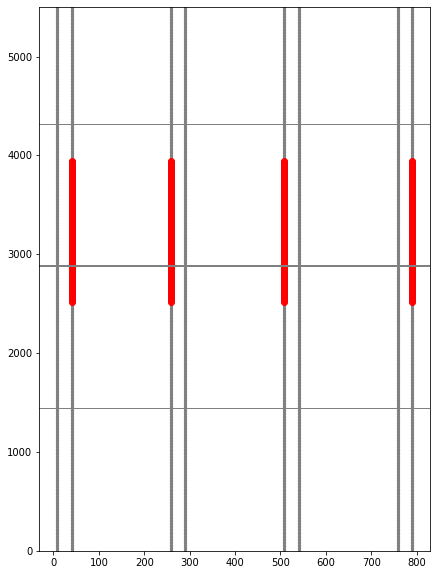

In [17]:
# works for 4 channel NP 2.0
#imro_path = '/home/sobolev/nevermind/AG_Pecka/data/raw/013608/config/imro/HPC_AudThalamus.imro'
#imro_path = '/home/sobolev/nevermind/AG_Pecka/data/raw/013608/config/imro/HPC_ALL.imro'
imro_path = '/home/sobolev/nevermind/AG_Pecka/data/raw/014393/config/imro/HPC.imro'

v_space = 15
x_coords = [[8, 40], [258, 290], [508, 540], [758, 790]]
y_coords = [v_space*x for x in range(640)]  # 15um vertical spacing, 640 channels each side

fig, ax = plt.subplots(1, 1, figsize=(7, 10))

# probe sites
for shank in range(4):
    x_l = x_coords[shank][0]
    x_r = x_coords[shank][1]
    
    ax.scatter(x_l * np.ones(len(y_coords)), y_coords, s=5, color='grey')
    ax.scatter(x_r * np.ones(len(y_coords)), y_coords, s=5, color='grey')
    
# 96 channels lines
for i in range(6):
    lw = 1 if i % 2 == 0 else 2
    ax.axhline(v_space * (i+1) * 96, color='grey', lw=lw)

    
# IMRO
imro_mx = imro2numpy(imro_path)
pos_mx  = np.zeros([len(imro_mx), 2])
for i, record in enumerate(imro_mx):
    shank = int(record[1])
    idx_x = int(record[4] % 2)
    pos_mx[i] = x_coords[shank][idx_x], v_space * int(record[4] / 2)
    
ax.scatter(pos_mx[:, 0], pos_mx[:, 1], color='red')

ax.set_ylim(0, 5500)

In [18]:
192 - (pos_mx[:, 1].min() / 15 + 96)

-29.0